In [35]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../../')
from paths import *

# this environmental variable must be set <before> the BID imports, to work with JAX double-precision
os.environ["JAX_ENABLE_X64"] = "True"
from dadapy.hamming import BID, Hamming

rcpsize = 20
plt.rcParams['xtick.labelsize']= rcpsize
plt.rcParams['ytick.labelsize']=rcpsize
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = rcpsize
plt.rcParams.update({'figure.autolayout': True})
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = plt.style.library['ggplot']['axes.prop_cycle'].by_key()['color']
colors = plt.style.library['seaborn-v0_8']['axes.prop_cycle'].by_key()['color']
colors = plt.style.library['seaborn-v0_8-dark-palette']['axes.prop_cycle'].by_key()['color']
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)
# print(plt.rcParams.keys())
#np.set_printoptions(precision=None)
markers = ['p','o','h','^','s']
plot_id = 0

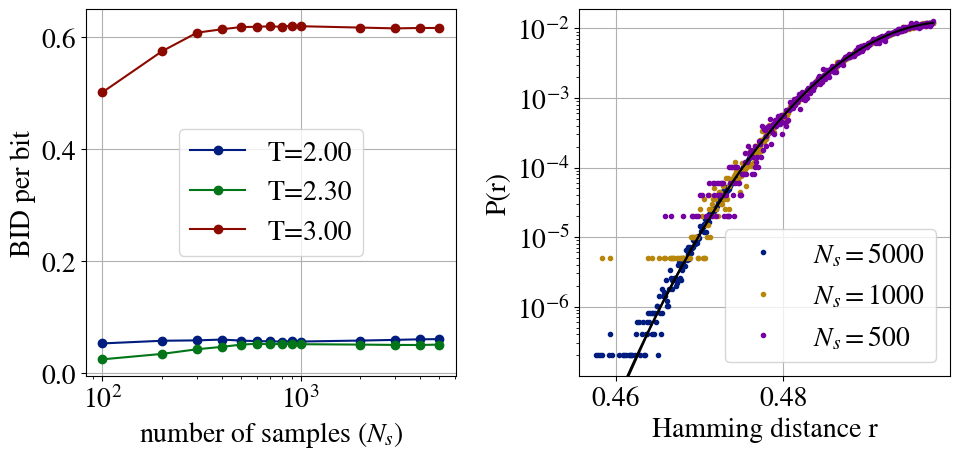

In [102]:
fig,ax = plt.subplots(1,2,figsize=(10,5))


Ns_list = np.arange(100,1000+1,100,dtype=int)
Ns_list = np.concatenate((Ns_list,
                          np.arange(2000,5000+1,1000,dtype=int)))
Ns_list = np.flip(Ns_list)
Ns_show = [500,1000,5000]
d0_list = np.empty(shape=(len(Ns_list)))
logKL_list = np.empty(shape=(len(Ns_list)))

seed = 1
alphamin = 0.0       # order of min_quantile, to remove poorly sampled parts of the histogram if necessary (see Supp. Inf. of paper)

delta = 1e-3        # stochastic optimization step size
Nsteps = int(1e6)   # number of optimization steps
T_list = [2,2.3,3]
alphamax_list = [.4,.4,.4]
# T_list = [2.3]
# alphamax_list = [.2]
L = 100
N = L**2
m = 999999
M = 0
for T_id,T in enumerate(T_list):
  alphamax = alphamax_list[T_id]
  for Ns_id,Ns in enumerate(Ns_list):
    optfolder0 = f"results/opt/L{L}/T{T:.2f}/Ns{Ns}/"  # folder where optimization results are saved
    B = BID(
            alphamin=alphamin,
            alphamax=alphamax,
            seed=seed,
            delta=delta,
            Nsteps=Nsteps,
            optfolder0=optfolder0
            )
    (_,
    d0_list[Ns_id],
    _,
    logKL_list[Ns_id], # logarithm of the KL divergence after optimization
    ) = B.load_results()
    remp,Pemp,Pmodel = B.load_fit()    # to do explicit model validation
    if T == 3. and Ns in Ns_show:
      ax[1].plot(remp/N,Pemp,'.',color=colors[Ns_id%len(colors)],label=r'$N_s=$' + f'{Ns}')
      ax[1].plot(remp/N,Pmodel,'-',color='black')
      m = np.min((np.min(Pemp),m))
      M = np.max((np.max(Pemp),M))

  ax[0].plot(Ns_list,d0_list / N, marker='o',label=f'{T=:.2f}')

ax[0].set_xlabel('number of samples '+ r'$(N_s)$')
ax[0].set_ylabel('BID per bit')
ax[1].set_ylabel('P(r)')
ax[1].set_xlabel('Hamming distance r')

ax[0].set_xscale('log')
# ax[0].set_yscale('log')

ax[1].set_yscale('log')
ax[1].set_ylim(m*.5,M*1.5)

ax[0].grid()
ax[1].grid()

ax[0].legend(loc='center')
ax[1].legend(loc='lower right')
# box = ax[1].get_position()
# ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [103]:
fig.savefig('results/Nsamples_dependence.pdf')